In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from scipy.sparse import find

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import pickle
import scipy.sparse


In [2]:
def cross_validate_models(X,y,clf_models, seen_index, n_splits=10, classes=None):

    kf = KFold(n_splits=10)
    i=0
    

    for model in clf_models:
        model['p'] = []
        model['r'] = []
        model['e'] = []
        model['i'] = []
        metrics = ['e']        
        if classes:
            model['cov_err'] = []
            model['LRAP'] = []
            model['LRL'] = []
            for j, y_class in enumerate(classes):
                model[f'p\n{y_class}'] = []
                model[f'r\n{y_class}'] = []
                metrics += [f'p\n{y_class}', f'r\n{y_class}']


    for k_train, k_test in kf.split(seen_index):
        k_train = seen_index[k_train]
        k_test = seen_index[k_test]
        i+=1
        print(i)
        for model in clf_models:
            clf = model['model']
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(X[k_train],y[k_train])
            predictions = clf.predict(X[k_test])
            model['e'].append(clf.score(X[k_test],y[k_test]))
            if classes:
                model['cov_err'].append(coverage_error(predictions, y[k_test,:]))
                model['LRAP'].append(label_ranking_average_precision_score(predictions, y[k_test,:]))
                model['LRL'].append(label_ranking_loss(predictions, y[k_test,:]))
                for j, y_class in enumerate(classes):
                    model[f'p\n{y_class}'].append(precision_score(predictions[:,j],y[k_test,j]))
                    model[f'r\n{y_class}'].append(recall_score(predictions[:,j],y[k_test,j]))
            else:
                # Precision
                model['p'].append(precision_score(predictions,y[k_test]))
                # Recall
                model['r'].append(recall_score(predictions,y[k_test]))
            
    if classes:
        return clf_models, metrics
    else:
        return clf_models

def plot_model_output(models, metrics, fig, axs):
    
    for i, model in enumerate(models):
        ax = axs[i]
        ax.boxplot([model[x] for x in metrics])

        for i,s in enumerate(metrics):
            ys = model[s]
            x = np.random.normal(i+1, 0.04, size=len(ys))
            ax.plot(x, ys, 'r.', alpha=0.2)

        ax.set_xticklabels([x for x in metrics], rotation=45, ha="right")

        ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
        ax.grid()

    fig.tight_layout()
                     
m_metrics = ['e','cov_err', 'LRAP','LRL']
plt.rcParams['grid.linestyle'] = "--"

In [3]:
pid = 178
qid = 7368
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

print(q.doc_set.count())

318385


### Collect the AR5 docs

In [4]:
ar5_docs = Doc.objects.filter(query=6956, content__iregex="\w").exclude(
    pk__in=[
        1461495, # Espinoza 2013
        1626875, # White, 2007
        1622783, # Why is Oliveira, 2007 included?
        1627593, # Killeen 2008
        1627701, # Also, Nepstad and Stickler, 2008
        2093363, # Etter
        2090005, # Nepstad, 2006
        1627734, # Polidoro 2010
        2089982, # Mars, 2007
        2090013, # Randolph 2010
        2093360, # Petney 2012
        2089960, # Wassenaar, 2007 - LUC
        1627733, # Polidoro 2010, very weak - not main conclusion
        2090004, # Veran 2007 - long line fishing
        2089967, # Giri - mangrove database, climate only mentioned in conclusion and with reference
        2089944, # Jellyman - eels
        2091676, # Novelo-Casanova, 2010: Cayman Islands climate??
        2089959, # Bruno, 2007 
        1514856, # de Waroux 2012
        2091680, # Guzman, 2008, we consider the main anthropogenic threats to the coral reefs and communities of the islands are overfishing, sedimentation and tourism
        2089950
    ]
)

ar5_ids = set(ar5_docs.values_list('pk',flat=True))

ar5_docs.count()

257

### Collect the rated documents and merge with the ar5s

In [5]:
seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))

print("seen docs",len(seen))

all_seen_ids = seen | ar5_ids
seen_docs = Doc.objects.filter(pk__in=all_seen_ids)
seen_docs.count()

seen docs 637


894

### Collect all the other unrated documents

In [6]:
unseen_docs = q.doc_set.filter(content__iregex='\w').exclude(pk__in=all_seen_ids).distinct('id')

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(316538, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,20,The responsiveness of South African fauna to c...,Vulnerability of South African animal taxa to ...,conservation; fragmentation; land-use; range c...,[Biodiversity Conservation; Ecology; Environme...,0,0
1,26,Physical and chemical limnological variables w...,Physical and chemical limnological characteris...,warming climate; high-latitude lakes; polar li...,[Limnology; Marine & Freshwater Biology],0,0
2,35,The Government of Saskatchewan is evaluating w...,First-Rotation Yields of 30 Short-Rotation Wil...,Short-rotation coppice (SRC); Salix; Bioenergy...,[Energy & Fuels; Environmental Sciences],0,0
3,46,Glaciers store water over a range of temporal ...,A review of methods for estimating the contrib...,climate change; glacier meltwater; hydrologica...,"[Geography, Physical; Geosciences, Multidiscip...",0,0
4,48,Using outgoing longwave radiation (OLR) and Tr...,The influence of Amazon rainfall on the Atlant...,None,[Meteorology & Atmospheric Sciences],0,0


### Mark the ar5 and rated documents as relevant 0 or 1

In [7]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])

    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if not dos.exists():
        if r['id'] in ar5_ids:
            r['relevant'] = 1
            r['ar5'] = 1
            r_docs.append(r)
    elif len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2:
            r['relevant'] = 0
        else:
            continue
        r['ar5'] = 0
        r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant", "ar5"]]
seen_df['seen'] = 1
print(seen_df.shape)
seen_df.head()

(819, 8)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,ar5,seen
0,1599,Although climate change is predicted to place ...,Climate-associated population declines reverse...,alpine plants; Argyroxyphium sandwicense; biod...,[Biodiversity Conservation; Ecology; Environme...,1,1,1
1,1782,The relation between changes in modern glacier...,Twentieth century climate change: Evidence fro...,None,[Multidisciplinary Sciences],1,0,1
2,2270,Species movements in relation with global warm...,Increasing southern invasion enhances congruen...,Atlantic Ocean; Biotic homogenization; Climate...,[Biodiversity Conservation; Ecology],1,1,1
3,5570,The south-eastern coast of Australia is recogn...,Climate-driven range changes in Tasmanian inte...,climate change; distribution change; latitudin...,[Fisheries; Limnology; Marine & Freshwater Bio...,1,1,1
4,5623,The Late Cenozoic development of the River Tan...,Late Cenozoic fluvial dynamics of the River Ta...,None,"[Geography, Physical; Geosciences, Multidiscip...",0,0,1


In [8]:
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)
y = df['relevant']
df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,ar5,seen
0,1277089,The Atlantic meridional overturning circulatio...,Anomalously weak Labrador Sea convection and A...,None,[Multidisciplinary Sciences],0,NaN,0
1,600118,"Kelp habitats provide food, refuge, and enhanc...",Settlement and early survival of southern rock...,climate change; early survival; Jasus edwardsi...,[Fisheries; Marine & Freshwater Biology; Ocean...,0,NaN,0
2,511041,"In this paper, we present regional climate cha...","Climate change projections for Tamil Nadu, Ind...",None,[Meteorology & Atmospheric Sciences],0,NaN,0
3,187739,The snow-masking effect of vegetation exerts s...,Vegetation controls on northern high latitude ...,albedo; arctic; boreal forest; climate feedbac...,[Biodiversity Conservation; Ecology; Environme...,0,NaN,0
4,788626,Background. British mosquito population distri...,Pond dyes are Culex mosquito oviposition attra...,Urban ecology; British mosquito; Culex pipiens...,[Multidisciplinary Sciences],0,NaN,0


In [9]:
cats = Category.objects.filter(project=p)
ldf = pd.DataFrame.from_dict(list(seen_docs.filter(
    category__in=cats
).values('id','category__name')))
ldf['v'] = 1

cat_map = ldf.pivot(index='id',columns="category__name", values="v")
cat_map['id'] = cat_map.index
cat_map = cat_map.reset_index(drop=True)

df = pd.merge(df, cat_map, how="left").fillna(0)

print(df.shape)
df.head()

(317357, 64)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,ar5,seen,01. Extreme water levels,02. Sea ice retreat,...,Rivers lakes and moisture,"Rivers, lakes, floods and/or drought",Seagrass,Small Islands,Terrestrial (eco-)systems,Terrestrial ES,Terrestrial ecosystems,Unclear,Weather sensitivity,Wildfire
0,1277089,The Atlantic meridional overturning circulatio...,Anomalously weak Labrador Sea convection and A...,0,[Multidisciplinary Sciences],0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,600118,"Kelp habitats provide food, refuge, and enhanc...",Settlement and early survival of southern rock...,climate change; early survival; Jasus edwardsi...,[Fisheries; Marine & Freshwater Biology; Ocean...,0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,511041,"In this paper, we present regional climate cha...","Climate change projections for Tamil Nadu, Ind...",0,[Meteorology & Atmospheric Sciences],0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,187739,The snow-masking effect of vegetation exerts s...,Vegetation controls on northern high latitude ...,albedo; arctic; boreal forest; climate feedbac...,[Biodiversity Conservation; Ecology; Environme...,0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,788626,Background. British mosquito population distri...,Pond dyes are Culex mosquito oviposition attra...,Urban ecology; British mosquito; Culex pipiens...,[Multidisciplinary Sciences],0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

new_index = df[(df['seen']==1) & (df['ar5']==0)].index

### Get a dictionary of category types

In [11]:
django.db.connection.close()
cat_dict = {}
for c in Category.objects.filter(project=p, level=1):
    cat_dict[c.name.replace('<hidden>','').strip()] = list(
        c.child_category.exclude(name="not included in table").values_list('name',flat = True)
    )
    
cat_dict

{'AR5 Category': ['Terrestrial ES',
  'Mountains, snow and ice',
  'Human and managed',
  'Oceans and Coasts',
  'Rivers lakes and moisture'],
 'AR5 Symbol': ['Glaciers, snow, ice and/or permafrost',
  'Marine ecosystems',
  'Coastal erosion and/or sea level effects',
  'Terrestrial ecosystems',
  'Rivers, lakes, floods and/or drought',
  'Livelihoods, health and/or economics',
  'Wildfire',
  'Food production'],
 'AR6 Category': ['Cryosphere',
  'Terrestrial (eco-)systems',
  'River floods',
  'Droughts',
  'Coastal human systems',
  'Marine (eco-)systems'],
 'AR6 Impact': ['07. Changes in warm water corals',
  '01. Extreme water levels',
  'Seagrass',
  '21. Health',
  '20. Economic development and inequality',
  '19. Conflict',
  '18. Displacement and migrations',
  '17. Malnutrition',
  '08. Species metabolism',
  '16. Armed conflict',
  'Food prices',
  '15. Coastal human systems',
  '14. Crop yields',
  '13. River floods',
  '10. Shifts in phenology (land)',
  '12. Drought freque

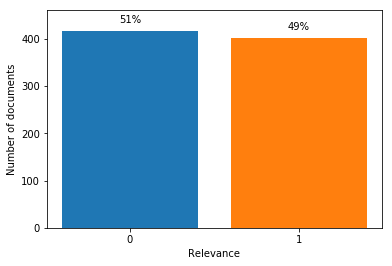

In [12]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
y = df['relevant']
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')

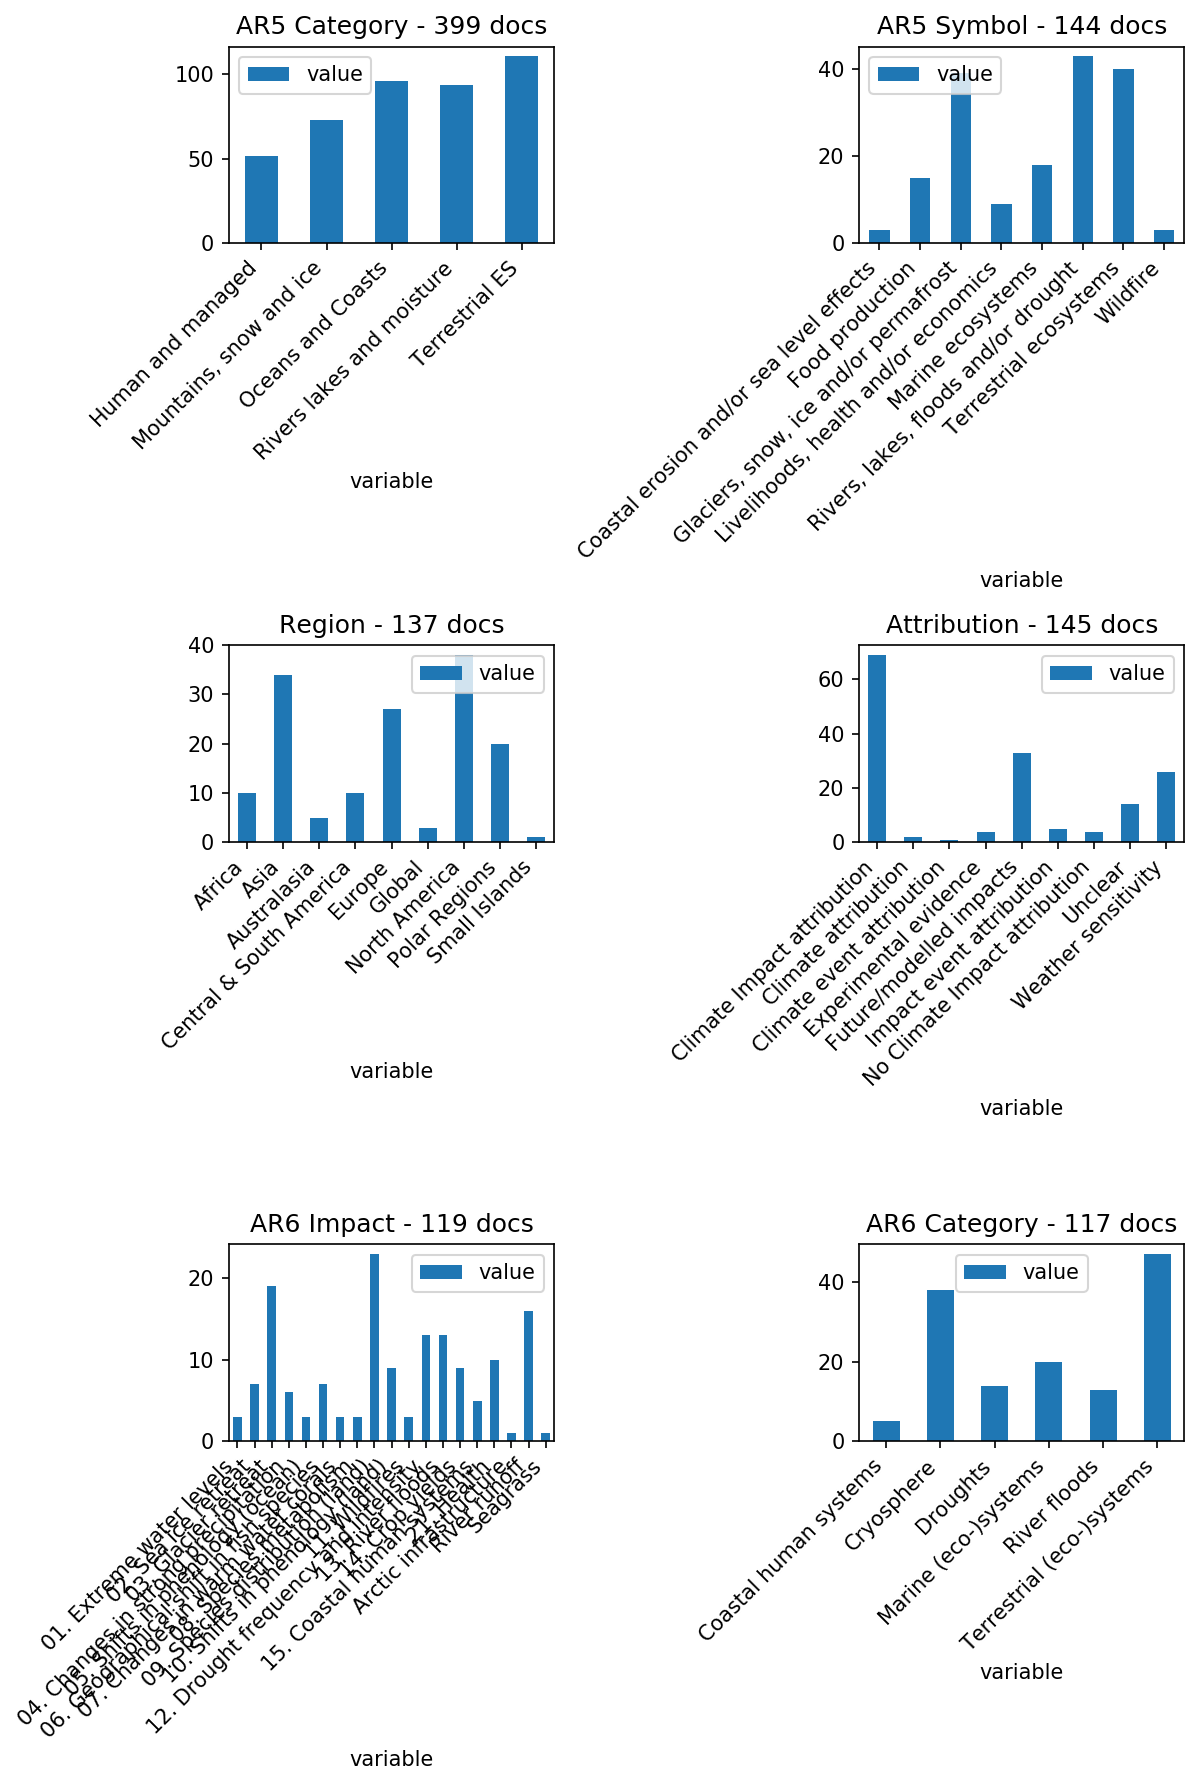

In [13]:
fig = plt.figure(figsize=(8,12),dpi=150)
for i, (n, v) in enumerate(cat_dict.items()):
    v = df.columns.intersection(v)
    ax = fig.add_subplot(3,2,i+1)
    pdf = df.loc[df['relevant']==1,v] 
    pdf['any'] = pdf.sum(axis=1)
    ndocs = pdf['any'].astype("bool").sum()
    pdf = pdf[v].melt()
    
    pdf.groupby('variable').sum().plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right")
    ax.set_title(f"{n} - {ndocs} docs")
    
fig.tight_layout()

In [31]:
noar6 = df[(df['seen']==1) & (df['ar5']==0) & df['relevant']==1]
print(len(noar6.index))
noar6 = noar6[noar6[df.columns.intersection(cat_dict['AR6 Impact'])].sum(axis=1)==0]
noar6.shape

145


(26, 64)

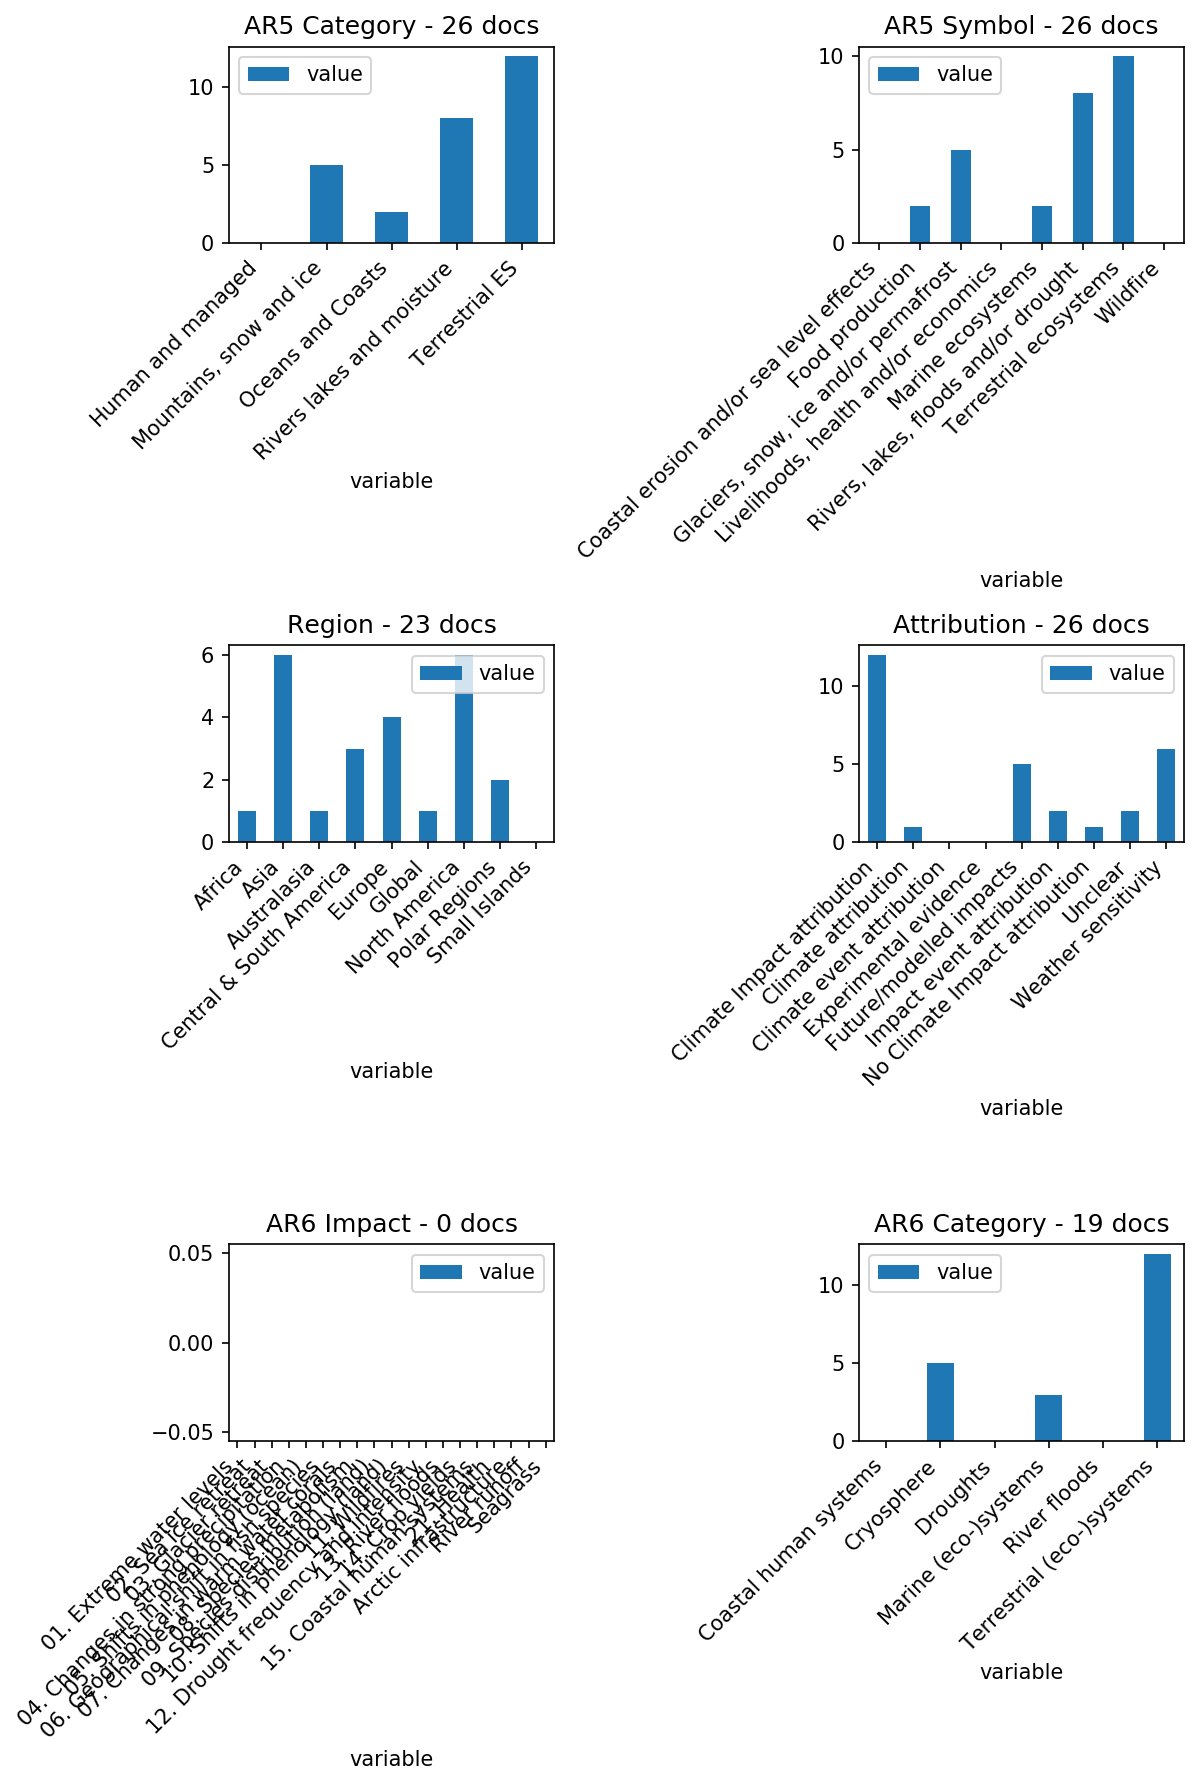

In [32]:
fig = plt.figure(figsize=(8,12),dpi=150)
for i, (n, v) in enumerate(cat_dict.items()):
    v = df.columns.intersection(v)
    ax = fig.add_subplot(3,2,i+1)
    pdf = noar6.loc[df['relevant']==1,v] 
    pdf['any'] = pdf.sum(axis=1)
    ndocs = pdf['any'].astype("bool").sum()
    pdf = pdf[v].melt()
    
    pdf.groupby('variable').sum().plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right")
    ax.set_title(f"{n} - {ndocs} docs")
    
fig.tight_layout()

## Vectorize

In [15]:
revectorize = True
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,1),
        min_df=20, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("string"))   
    with open ('../data/vec.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz('../data/X.npz', X)
else:
    with open ('../data/vec.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz('../data/X.npz')

In [16]:
from sklearn.model_selection import KFold

y = df['relevant']

clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

clf_models = cross_validate_models(X, y, clf_models, seen_index)

1
2
3
4
5
6
7
8
9
10


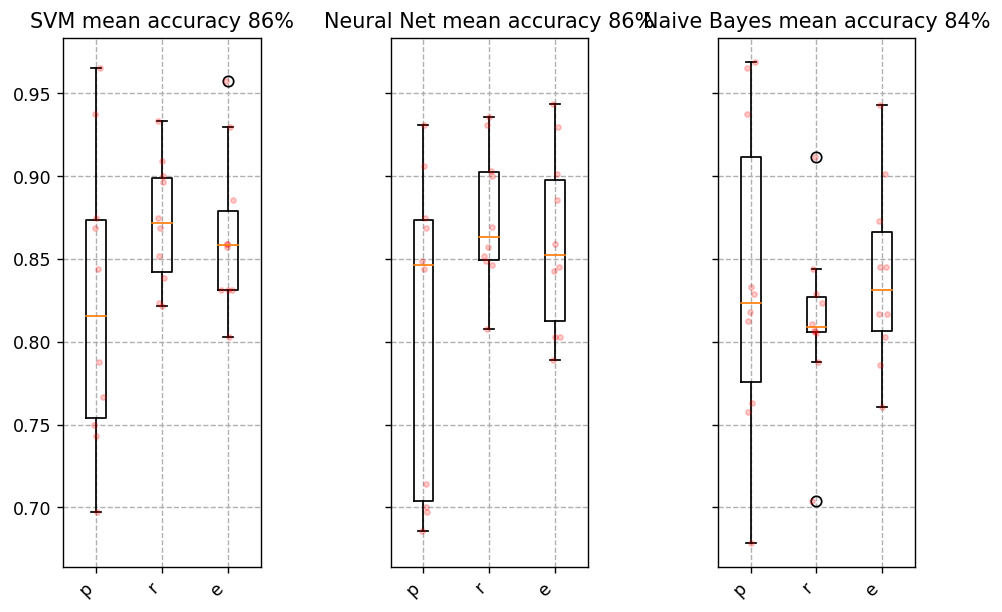

In [17]:
fig, axs = plt.subplots(1, len(clf_models),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(clf_models,  ['p','r','e'], fig, axs)
plt.show()

In [18]:
clf = SVC(kernel='linear',class_weight='balanced',probability=True)
clf.fit(X[seen_index],y[seen_index])
y_pred = clf.predict_proba(X[unseen_index])

In [19]:
df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

64664
316675


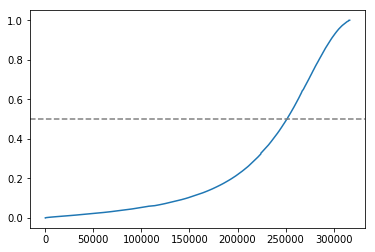

In [20]:
plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])

plt.show()

In [37]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

tag = Tag(
    title="predicted relevant sample {}".format(now),
    query=q
)
tag.save()

max_docs = 250
docs_added = 0
prel = True
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(tag)
            docs_added+=1
        else:
            break  
        if row['prediction'] < 0.5 and prel:
            print(docs_added)
            prel = False

    
tag.update_tag()

In [40]:
model_df = pd.DataFrame(clf_models)
model_df.to_csv(f"../data/doctables/models_rel_{now}.csv",index=False)
df[['id','prediction']].to_csv(f'../data/doctables/predictions_rel_{now}.csv',index=False)

In [41]:
y = df['Terrestrial ecosystems']

clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

ecosystem_models = cross_validate_models(X, y, clf_models, new_index)

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


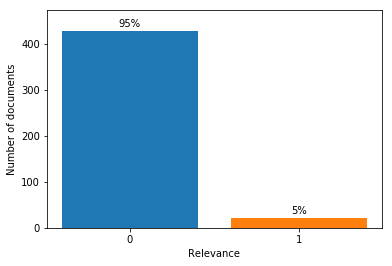

In [42]:
fig, ax = plt.subplots()

pdf = df[df.index.isin(new_index)]
n = pdf.shape[0]

for i, (name, group) in enumerate(pdf.groupby('Terrestrial ecosystems')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')

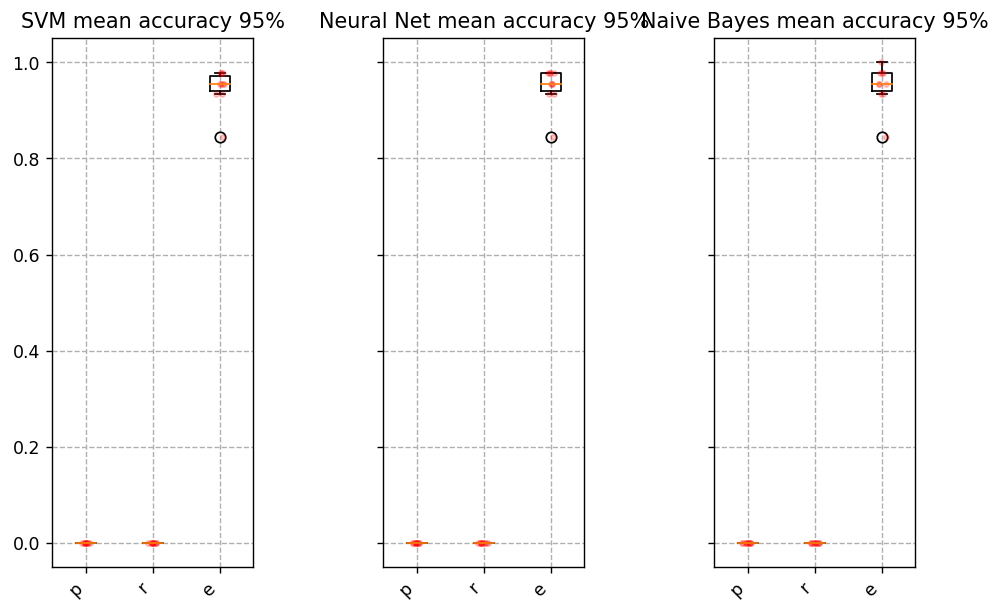

In [102]:
fig, axs = plt.subplots(1, len(ecosystem_models),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(ecosystem_models, ['p','r','e'], fig, axs)
plt.show()

In [44]:
model_df = pd.DataFrame(ecosystem_models)
model_df.to_csv(f"../data/doctables/models_ecosystem_{now}.csv",index=False)

(317383, 5)

In [73]:
from sklearn.model_selection import KFold

classes = cat_dict['AR5 Category']
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC', 
        'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    },
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels_ar5, metrics = cross_validate_models(X, y, multimodels, seen_index, classes=classes)


(317383, 5)
1
2


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


3
4
5


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


6


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


7


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


8
9
10


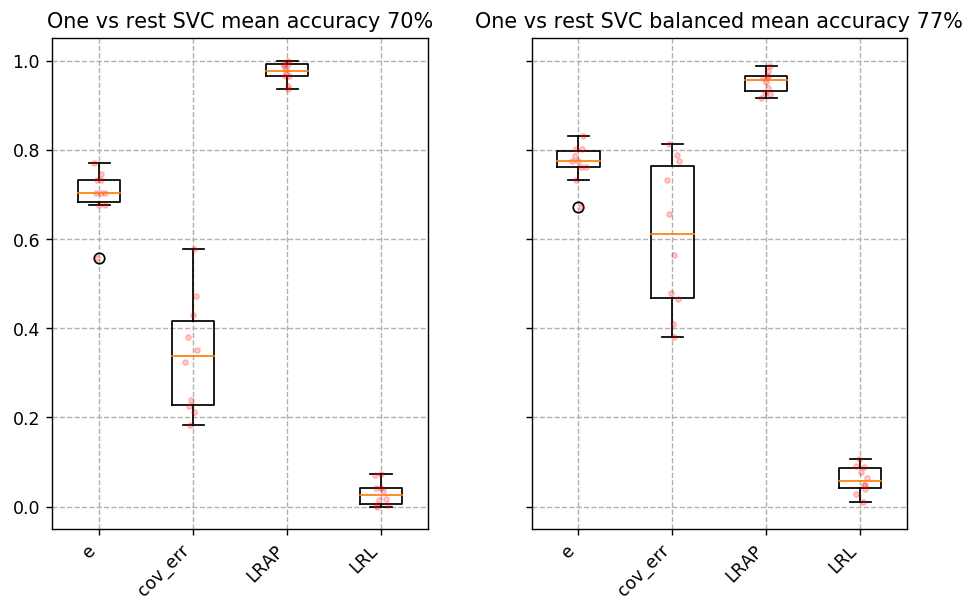

In [76]:
fig, axs = plt.subplots(1, len(multimodels_ar5),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(multimodels_ar5, m_metrics, fig, axs)
plt.show()

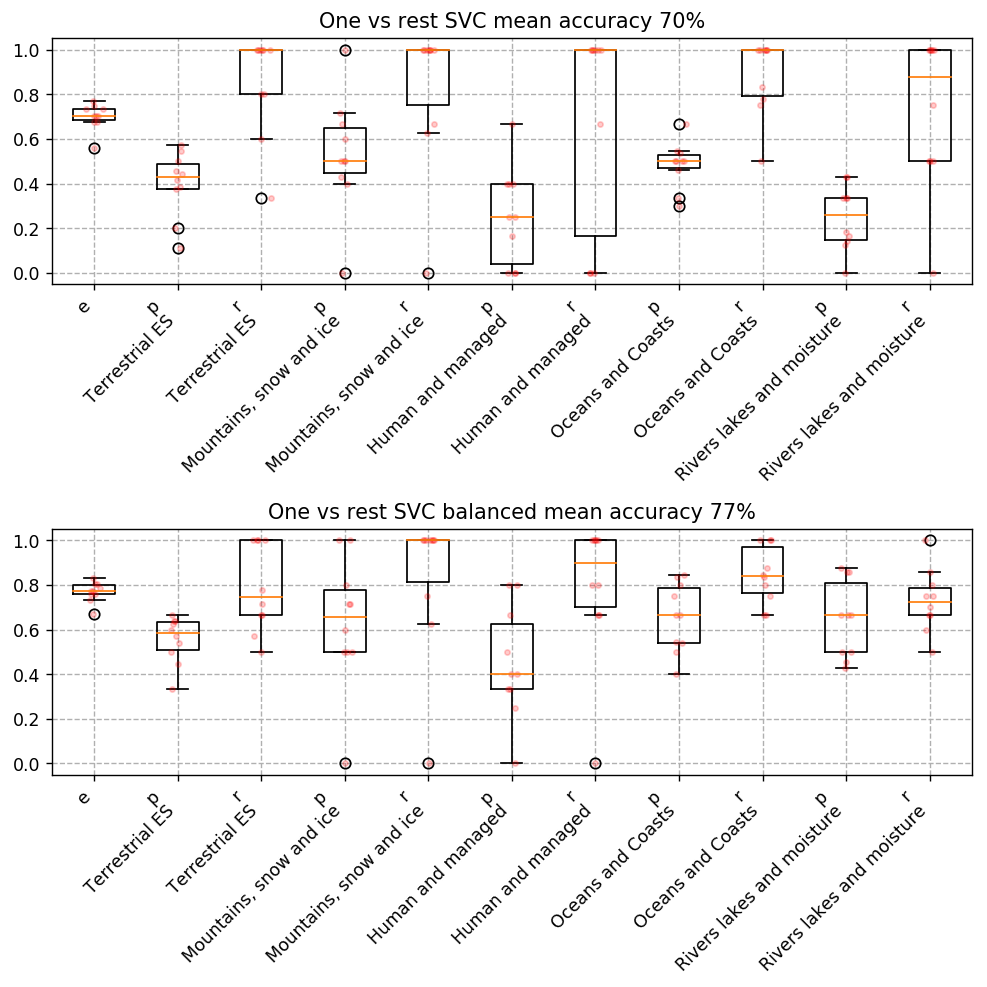

In [77]:
fig, axs = plt.subplots(1, len(multimodels_ar5),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(multimodels_ar5_symbol, metrics, fig, axs)
plt.show()

In [78]:
model_df = pd.DataFrame(multimodels_ar5)
model_df.to_csv(f"../data/doctables/models_multi_ar5_{now}.csv",index=False)

In [88]:
from sklearn.model_selection import KFold

classes = cat_dict['AR5 Symbol']
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC', 
        'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    },
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels_ar5_symbol, metrics = cross_validate_models(X, y, multimodels, new_index, classes=classes)

(317383, 8)
1


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


2


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


3


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


4


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


5


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


6


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 d

7


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


8


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


9


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


10


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


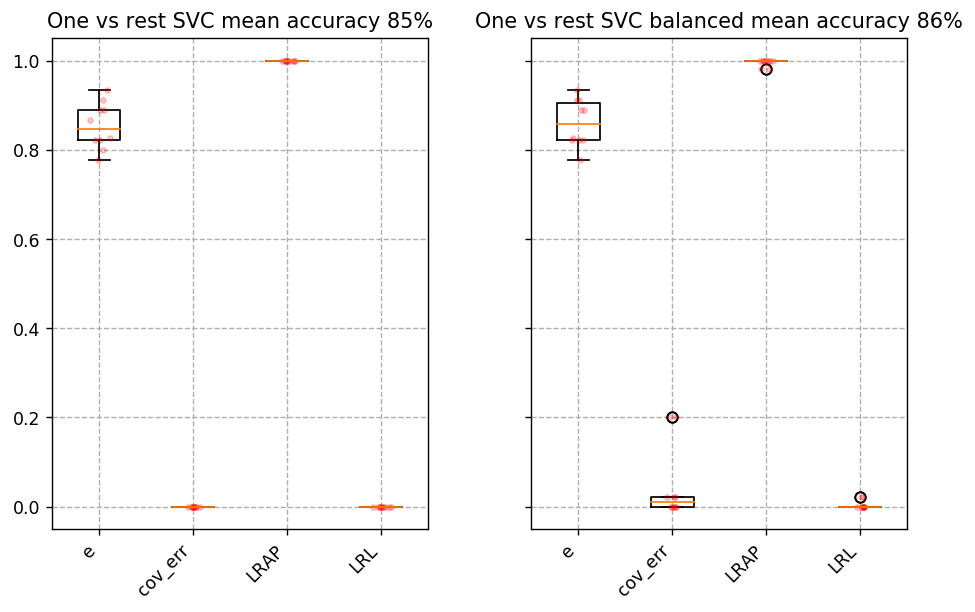

In [94]:
fig, axs = plt.subplots(1, len(multimodels_ar5_symbol),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(multimodels_ar5_symbol, m_metrics, fig, axs)
plt.show()

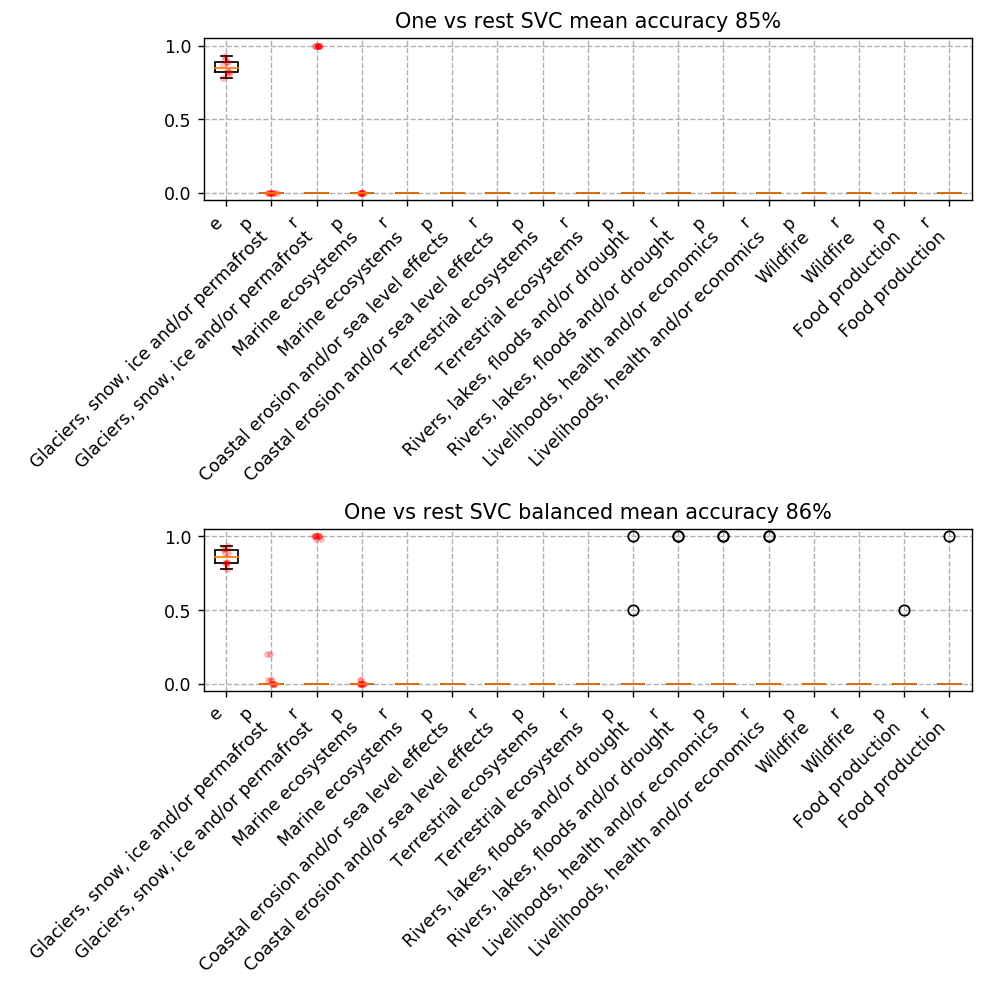

In [98]:
fig, axs = plt.subplots(len(multimodels_ar5_symbol),dpi=125,figsize=(8,8),sharey=True)
plot_model_output(multimodels_ar5_symbol, metrics, fig, axs)
plt.show()

In [91]:
model_df = pd.DataFrame(multimodels_ar5_symbol)
model_df.to_csv(f"../data/doctables/models_multi_ar5_symbol_{now}.csv",index=False)